Copyright (c) MONAI Consortium  
Licensed under the Apache License, Version 2.0 (the "License");  
you may not use this file except in compliance with the License.  
You may obtain a copy of the License at  
&nbsp;&nbsp;&nbsp;&nbsp;http://www.apache.org/licenses/LICENSE-2.0  
Unless required by applicable law or agreed to in writing, software  
distributed under the License is distributed on an "AS IS" BASIS,  
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.  
See the License for the specific language governing permissions and  
limitations under the License.

# Creating a randomized augmentation during training

While training, if a monai transform chain is defined. It so happens that all the images go through the same transformations. All the transformations are vector quantities, so switching the order of transforms will generate a new augmentation. In the present implementation if you apply any transform more than once, you need to write it multiple times. Instead we are proposing is that the users can specify a dictionary of name of transformation (like rotate, flip or translate etc) and the frequency of transformation (an integer like 1, 2, ). The Augmentation class will then generate random transformation chain on the fly during training. 
One of the cons of this approach is that the cache method probably cannot be used as the transformations are being generated at random 


## Setup environment

In [ ]:
!python -c "import monai" || pip install -q "monai-weekly"
!python -c "import matplotlib" || pip install -q matplotlib

## Setup imports

In [ ]:
import glob
from matplotlib import pyplot as plt
import numpy as np
from randomizedPermutations import AugmentData

from monai.config import print_config
from monai.transforms import LoadImage, Compose, Resize, ScaleIntensity, EnsureChannelFirst

print_config()

## Generate the image list

In [44]:
image_dir = "./exampleImages"
image_file_list = glob.glob(image_dir + "/*.png")
out_size = (200, 200)

# Check the image dimensions and number of channels
img = LoadImage(image_only=True)(image_file_list[0])
print(img.shape, np.min(img), np.max(img))

(278, 512) 0.0 255.0


As one can see that the image has no channels and the size is not standard, we need to add a channel and resize the image. 
Because the image intensity is between 0 and 255, we need to scale the intensity between 0 and 1. 

In [45]:
image_loading_transform_list = [
    LoadImage(image_only=True),
    EnsureChannelFirst(channel_dim="no_channel"),
    Resize(out_size),
    ScaleIntensity(),
]
img = Compose(image_loading_transform_list)(image_file_list[0])
print("Shape ", img.shape)
print("Intensity (min, max)", np.min(img), np.max(img))

Shape  (1, 200, 200)
Intensity (min, max) 0.0 1.0


In [46]:
# Set of image transforms needed for appropriately loading the image
image_loading_transforms = [LoadImage(image_only=True), EnsureChannelFirst(channel_dim="no_channel"), Resize(out_size)]

batch_size = 5
# Set of augmentations need to be applied
image_augmentation_dict = {"rotate": 3, "flip": 2, "rotate90": 4}
img = AugmentData(
    image_loading_transforms,
    augmentation_dict=image_augmentation_dict,
    output_size=out_size,
    batch_size=batch_size,
    num_augmentations=3,
)(image_file_list)
print(img.shape)

(5, 1, 200, 200)


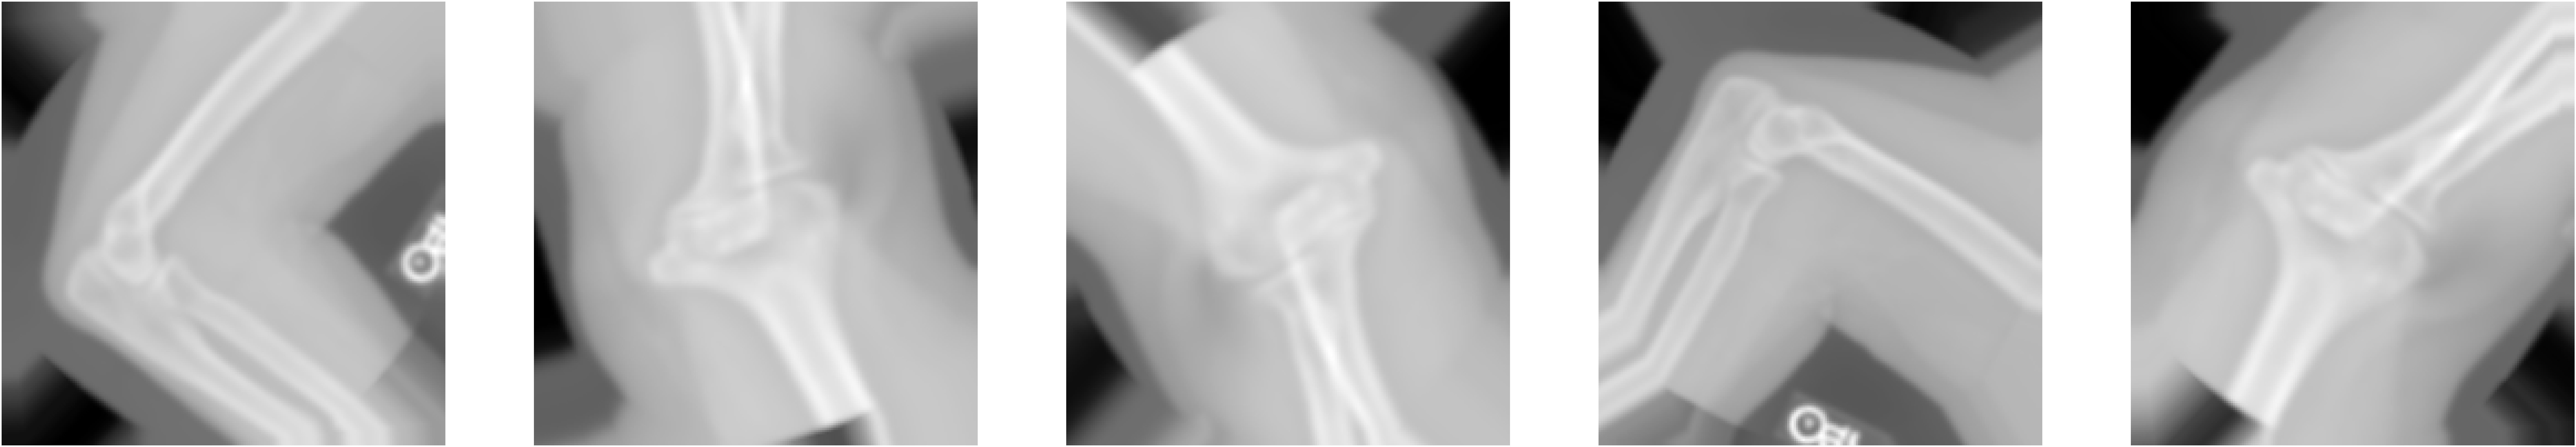

In [49]:
# Check the augmentations
fig = plt.figure(figsize=out_size)

for i in range(1, batch_size + 1):
    fig.add_subplot(1, batch_size, i)
    # Making these transforms to put the axis at the end, followed by copying the elements
    # to 3 channels for GRAY Scale representation
    a = np.repeat(np.transpose(img[i - 1, :, :, :], [1, 2, 0]), repeats=3, axis=2)
    plt.imshow(a)
    plt.axis("off")